# **Cluster Analysis Applied to Toronto's Neighborhoods**
---
**Pedro Guimarães Ferreira**

## 1) Importing the necessary libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import csv

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import os

from geopy.geocoders import Nominatim
import geocoder
import folium

from sklearn.cluster import KMeans

## 2) Accessing the wikipedia page and scraping its html, in order to get the required table:

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

soup = BeautifulSoup(source, 'lxml')

article_body = soup.find('div', class_='mw-parser-output')

table = article_body.find('table', class_='wikitable sortable')

## 3) Opening a csv file in write mode:

In [3]:
toronto_csv = open('toronto_postal_codes.csv', 'w')

csv_writer = csv.writer(toronto_csv)

## 4) Populating the headers and values of the Postal Codes' Table:

> ### 4.1) Populating the headers and writting them on the csv file:

In [4]:
headers_list = [table_header.text[0:-1] for table_header in table.find_all('th')]
csv_writer.writerow(headers_list)

34

> ### 4.2) Populating the table with due values by writting them on csv file, already splitted into 3 different columns ('Postal Code', 'Borough' and 'Neighborhood'):

In [5]:
values_list = [value.text[0:-1] for value in table.find_all('td')]

i = 0

for val in values_list:
    
    if values_list[i+1] == 'Not assigned':
        pass
    else:
        csv_writer.writerow([values_list[i], values_list[i+1], values_list[i+2]])
        
    if (i+2) == len(values_list)-1:
        break
    else:
        i += 3

### 5) Closing the csv file:

In [6]:
toronto_csv.close()

### 6) Reading the csv file into a pandas DataFrame, displaying it, as well as its shape:

In [7]:
toronto_df = pd.read_csv('toronto_postal_codes.csv')

In [8]:
toronto_df

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [9]:
toronto_df.shape

(103, 3)

### 7) Checking for duplicates in 'Postal Code' feature:

In [10]:
if toronto_df.shape[0] == len(toronto_df['Postal Code'].unique()):
    print("--- No duplicates found in Postal Codes'feature ---")

--- No duplicates found in Postal Codes'feature ---


In [11]:
duplicated_rows = toronto_df[toronto_df.duplicated(['Postal Code'])]
duplicated_rows #returns an empty dataframe

,Postal Code,Borough,Neighborhood


## 8) Getting the latitude and the longitude coordinates of each neighborhood:

> ### 8.1) Defining a function that returns the latitude and longitude of a given postal code in Toronto:

In [12]:
def getLatLng(postal_code):
    
    lat_lng = None
    
    while(lat_lng is None):
        g = geocoder.arcgis(f'{postal_code}, Toronto, Ontario')
        lat_lng = g.latlng
    
    return lat_lng

> ### 8.2) Applying the defined function to each of the postal code and creating 2 new columns in toronto_df, one for the latitude, another for the longitude of each neighborhood:

In [13]:
postal_codes = toronto_df['Postal Code'].tolist()
hood_lat_lng = [getLatLng(postal_code) for postal_code in postal_codes]

In [14]:
df_lat_lng = pd.DataFrame(hood_lat_lng, columns=['Latitude', 'Longitude'])
df_lat_lng.head()

,Latitude,Longitude
0,43.752935,-79.335641
1,43.728102,-79.311890
2,43.650964,-79.353041
3,43.723265,-79.451211
4,43.661790,-79.389390


In [15]:
toronto_df['Latitude'] = df_lat_lng.iloc[:, 0]
toronto_df['Longitude'] = df_lat_lng.iloc[:, 1]

In [16]:
toronto_df

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.752935,-79.335641
1,M4A,North York,Victoria Village,43.728102,-79.311890
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650964,-79.353041
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.723265,-79.451211
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.661790,-79.389390
5,M9A,Etobicoke,Islington Avenue,43.667481,-79.528953
6,M1B,Scarborough,"Malvern, Rouge",43.808626,-79.189913
7,M3B,North York,Don Mills,43.748900,-79.357220
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.707193,-79.311529
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657491,-79.377529


## 9) Opening and accessing my credentials (stored in a json file for privacy reasons) in order to use it in the Foursquare API:

In [17]:
filename = 'my_credentials.json'
with open(filename) as c:
    data = json.load(c)

In [18]:
CLIENT_ID = data['credentials']['CLIENT_ID']
CLIENT_SECRET = data['credentials']['CLIENT_SECRET']
VERSION = data['credentials']['VERSION']

## 10) Filtering the toronto_df in order to only use boroughs containing 'Toronto' in its name:

In [19]:
boroughs_df = toronto_df[toronto_df['Borough'].str.contains('Toronto')].reset_index(drop=True)

In [20]:
boroughs_df

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650964,-79.353041
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.661790,-79.389390
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657491,-79.377529
3,M5C,Downtown Toronto,St. James Town,43.651734,-79.375554
4,M4E,East Toronto,The Beaches,43.678148,-79.295349
5,M5E,Downtown Toronto,Berczy Park,43.645196,-79.373855
6,M5G,Downtown Toronto,Central Bay Street,43.656072,-79.385653
7,M6G,Downtown Toronto,Christie,43.668602,-79.420387
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650542,-79.384116
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.664910,-79.438664


> ### 10.1) Defining and using a function to retrieve all the venues contained in the neighborhoods of the boroughs_df, making calls on the Fousquare API (LIMIT = 100, radius = 500):

In [21]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL (one call for each neighborhood in our dataframe)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request to get all the venues of the current iteration
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue (each iterarion appends a new tuple)
        venues_list.append([(
            name, #neighborhood's name
            lat, #neighborhood's latitude
            lng, #neighborhood's logitude
            v['venue']['name'], #venue's name
            v['venue']['location']['lat'], #venue's latitude
            v['venue']['location']['lng'],  #venue's longitude
            v['venue']['categories'][0]['name']) for v in results]) #venue's category name
        
    #populating the nearby_venues dafaframe
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
boroughs_venues = getNearbyVenues(names = boroughs_df['Neighborhood'],
                                  latitudes = boroughs_df['Latitude'],
                                  longitudes = boroughs_df['Longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town,

> ### 10.2) Checking the shape and head of the boroughs_venues dataframe:

In [23]:
print(boroughs_venues.shape)
boroughs_venues.head()

(1585, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.650964,-79.353041,Souk Tabule,43.653756,-79.354390,Mediterranean Restaurant
1,"Regent Park, Harbourfront",43.650964,-79.353041,Young Centre for the Performing Arts,43.650825,-79.357593,Performing Arts Venue
2,"Regent Park, Harbourfront",43.650964,-79.353041,SOMA chocolatemaker,43.650622,-79.358127,Chocolate Shop
3,"Regent Park, Harbourfront",43.650964,-79.353041,BATLgrounds,43.647088,-79.351306,Athletics & Sports
4,"Regent Park, Harbourfront",43.650964,-79.353041,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant


> ### 10.3) Checking how many venues are there in each of the neighborhoods (reminder: LIMIT = 100), as well as how many unique venues categories amongst all neighborhoods

In [24]:
(boroughs_venues['Neighborhood'].value_counts()).to_frame()

,Neighborhood
Stn A PO Boxes,100
"First Canadian Place, Underground city",100
"Garden District, Ryerson",100
"Toronto Dominion Centre, Design Exchange",100
Business reply mail Processing Centre,100
"Richmond, Adelaide, King",100
"Commerce Court, Victoria Hotel",100
Church and Wellesley,81
St. James Town,75
"Parkdale, Roncesvalles",69


In [25]:
print('--- There are '+str(len(boroughs_venues['Venue Category'].unique()))+' unique venue categories ---')

--- There are 223 unique venue categories ---


## 11) Analyzing each neigborhood

> ### 11.1) One hot encoding for the feature 'Venue Category'

In [26]:
hoods_venues = pd.get_dummies(boroughs_venues[['Venue Category']], prefix='', prefix_sep='')
hoods_venues['Neighborhood'] = boroughs_venues['Neighborhood']
print(hoods_venues.shape)
hoods_venues.head()

(1585, 223)


,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfro

> ### 11.2) Reordering the columns so that the 'Neighborhood' column becomes the first column on hoods_venues dataframe

In [27]:
reordered_columns = [hoods_venues.columns[hoods_venues.columns.get_loc('Neighborhood')]]+\
                    list(hoods_venues.columns[:(hoods_venues.columns.get_loc('Neighborhood'))])+\
                    list(hoods_venues.columns[(hoods_venues.columns.get_loc('Neighborhood')+1):])

In [28]:
hoods_venues = hoods_venues[reordered_columns]
print(hoods_venues.shape) #shape remains the same after reordering the columns, as it should
hoods_venues.head()

(1585, 223)


,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

> ### 11.3) Grouping the hoods_venues dataframe by 'Neighborhood' using .mean() as the aggregate function, in order to produce a frequency table of each venue category for each of the neighborhoods:

In [29]:
neigh_grouped = hoods_venues.groupby('Neighborhood').mean().reset_index()

In [30]:
print(neigh_grouped.shape) #39 distinct neighborhoods
neigh_grouped.head()

(39, 223)


,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.0,0.00,0.0,0.015152,0.00,0.000000,0.000000,0.0,0.015152,0.0,0.015152,0.030303,0.000000,0.000000,0.0,0.015152,0.000000,0.030303,0.0,0.0,0.015152,0.00,0.000000,0.00,0.030303,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.030303,0.0,0.000000,0.030303,0.0,0.000000,0.00,0.0,0.015152,0.045455,0.090909,0.0,0.0,0.000000,0.0,0.0,0.015152,0.00,0.015152,0.0,0.015152,0.00,0.015152,0.0,0.0,0.000000,0.015152,0.00,0.0,0.015152,0.0,0.0,0.0,0.000000,0.015152,0.0,0.0,0.0,0.000000,0.0,0.015152,0.015152,0.000000,0.015152,0.0,0.0,0.0,0.00,0.015152,0.015152,0.015152,0.0,0.00,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.0,0.015152,0.0,0.015152,0.015152,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.030303,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0

> ### 11.4) Inspecting the 5 most frequent venues of each neighborhood:

In [31]:
top_venues = 5

for neighborhood in neigh_grouped['Neighborhood']:
    print('--- '+neighborhood+' ---')
    temp = neigh_grouped[neigh_grouped['Neighborhood'] == neighborhood].T.reset_index()
    temp.columns = ['Venue', 'Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(top_venues))
    print()

--- Berczy Park ---
          Venue  Frequency
0   Coffee Shop       0.09
1  Cocktail Bar       0.05
2   Cheese Shop       0.03
3        Lounge       0.03
4          Café       0.03

--- Brockton, Parkdale Village, Exhibition Place ---
                    Venue  Frequency
0                    Café       0.07
1             Coffee Shop       0.07
2             Pizza Place       0.05
3               Gift Shop       0.05
4  Thrift / Vintage Store       0.05

--- Business reply mail Processing Centre ---
                 Venue  Frequency
0          Coffee Shop       0.07
1                Hotel       0.05
2           Restaurant       0.04
3  Japanese Restaurant       0.04
4                 Café       0.04

--- CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport ---
               Venue  Frequency
0               Café       0.06
1        Coffee Shop       0.06
2               Park       0.05
3  French Restaurant       0.05
4         Resta

> ### 11.5) Defining a function to order a given row and return its n first index values

In [32]:
def orderIndexValues(row, n_first_values):
    ordered_row = row.iloc[1:].sort_values(ascending=False)
    ordered_index_values = ordered_row.index.values[:n_first_values]
    return ordered_index_values

> ### 11.6) Instanciating a dataframe to be populated with the 10 most common venue categories for each neighborhood

In [33]:
#naming its columns
num_top_venues = 10
first_3 = ['st', 'nd', 'rd']
columns = ['Neighborhood'] #first column's name

for i in range(num_top_venues): #naming the remaining columns
    try:
        columns.append(f'{i+1}{first_3[i]} Most Common Venue')
    except:
        columns.append(f'{i+1}th Most Common Venue')
        
#instanciating the dataframe
sorted_hoods_venues = pd.DataFrame(columns=columns)
sorted_hoods_venues['Neighborhood'] = neigh_grouped['Neighborhood']

> ### 11.7) Populating the sorted_hoods_venues dataframe using the OrderIndexValues function

In [34]:
for i in range(neigh_grouped.shape[0]):
    sorted_hoods_venues.iloc[i, 1:] = orderIndexValues(neigh_grouped.iloc[i], num_top_venues)

In [35]:
sorted_hoods_venues.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Breakfast Spot,Seafood Restaurant,Bakery,Lounge,Café,Restaurant,Hotel,Cheese Shop
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Thrift / Vintage Store,Diner,Pizza Place,Gift Shop,Boutique,Italian Restaurant,Japanese Restaurant,Brewery
2,Business reply mail Processing Centre,Coffee Shop,Hotel,Restaurant,Café,Japanese Restaurant,Asian Restaurant,Tea Room,Concert Hall,Bookstore,Steakhouse
3,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Café,Restaurant,French Restaurant,Park,Speakeasy,Lounge,Italian Restaurant,Japanese Restaurant,Bar
4,Central Bay Street,Coffee Shop,Middle Eastern Restaurant,Restaurant,Sandwich Place,Bubble Tea Shop,Plaza,Japanese Restaurant,Clothing Store,Café,Department Store


## 12) Clustering the Neighborhoods into 5 clusters using k-means 

In [36]:
neigh_grouped_clustering = neigh_grouped.drop('Neighborhood', 1) #dropping categorical feature

In [37]:
k=5
kmeans = KMeans(init='k-means++', n_clusters=k, n_init=12).fit(neigh_grouped_clustering)

> ### 12.1) Insert a column containing the Cluster Labels provided by K-means into sorted_hoods_venues dataframe and merging it with boroughs_df dataframe

In [38]:
sorted_hoods_venues.insert(0, 'Cluster Labels', kmeans.labels_)
sorted_hoods_venues

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Berczy Park,Coffee Shop,Cocktail Bar,Breakfast Spot,Seafood Restaurant,Bakery,Lounge,Café,Restaurant,Hotel,Cheese Shop
1,0,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Thrift / Vintage Store,Diner,Pizza Place,Gift Shop,Boutique,Italian Restaurant,Japanese Restaurant,Brewery
2,0,Business reply mail Processing Centre,Coffee Shop,Hotel,Restaurant,Café,Japanese Restaurant,Asian Restaurant,Tea Room,Concert Hall,Bookstore,Steakhouse
3,0,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Café,Restaurant,French Restaurant,Park,Speakeasy,Lounge,Italian Restaurant,Japanese Restaurant,Bar
4,0,Central Bay Street,Coffee Shop,Middle Eastern Restaurant,Restaurant,Sandwich Place,Bubble Tea Shop,Plaza,Japanese Restaurant,Clothing Store,Café,Department Store
5,4,Christie,Grocery Store,Café,Playground,Candy Store,Baby Store,Athletics & Sports,Coffee Shop,Park,Fish & Chips Shop,Elementary School
6,0,Church and Wellesley,Coffee Shop,Japanese Restaurant,Restaurant,Sushi Restaurant,Pub,Café,Hotel,Gastropub,Mediterranean Restaurant,Dance Studio
7,0,"Commerce Court, Victoria Hotel",Coffee Shop,Restaurant,Café,Italian Restaurant,Hotel,Gym,American Restaurant,Japanese Restaurant,Deli / Bodega,Seafood Restaurant
8,0,Davisville,Café,Dessert Shop,Italian Restaurant,Sandwich Place,Pizza Place,Coffee Shop,Thai Restaurant,Seafood Restaurant,Park,Sushi Restaurant
9,4,Davisville North,Food & Drink Shop,Breakfast Spot,Department Store,Park,Gym,Electronics Store,Food,Flower Shop,Fish Market,Fish & Chips Shop


In [39]:
sorted_hoods_venues['Cluster Labels'].value_counts().to_frame()

,Cluster Labels
0,28
4,8
3,1
2,1
1,1


In [40]:
boroughs_df = boroughs_df.join(sorted_hoods_venues.set_index('Neighborhood'), on='Neighborhood')
boroughs_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650964,-79.353041,0,Pub,Café,Coffee Shop,Athletics & Sports,Optical Shop,Tech Startup,Mexican Restaurant,Food Truck,Restaurant,French Restaurant
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.661790,-79.389390,0,Coffee Shop,Café,Sushi Restaurant,Bank,Sandwich Place,Middle Eastern Restaurant,Burrito Place,Restaurant,Fried Chicken Joint,Bookstore
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657491,-79.377529,0,Coffee Shop,Clothing Store,Sandwich Place,Middle Eastern Restaurant,Italian Restaurant,Café,Cosmetics Shop,Bar,Hotel,Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651734,-79.375554,0,Coffee Shop,Café,Seafood Restaurant,Cocktail Bar,Gastropub,Cosmetics Shop,American Restaurant,Gym,Theater,Italian Restaurant
4,M4E,East Toronto,The Beaches,43.678148,-79.295349,0,Church,Health Food Store,Trail,Pub,Yoga Studio,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market


In [41]:
boroughs_df['Cluster Labels'].value_counts().to_frame()

,Cluster Labels
0,28
4,8
3,1
2,1
1,1


## 13) Visualizing the clustered neighborhoods in a map using folium

> ### 13.1) Getting Toronto's coordinates and instanciating a folium Map object

In [42]:
address = 'Toronto, Canada'
geolocator = Nominatim(user_agent='explorer')
location = geolocator.geocode(address)
latitude, longitude = location.latitude, location.longitude

In [43]:
clusters_map = folium.Map(location = [latitude, longitude],
                          zoom_start = 11
                         )

> ### 13.2) Setting a color scheme for the different clusters

In [44]:
x = np.arange(k)
ys = [i+i*x**2 for i in range(k)]

colors_array = cm.tab20b(np.linspace(0, 1, len(ys)))
pallete = [colors.rgb2hex(i) for i in colors_array]

> ### 13.3) Adding Circle Marker and Popup objects for each of the data points in boroughs_df

In [45]:
for lat, lng, neigh, cluster in zip(boroughs_df['Latitude'], boroughs_df['Longitude'], boroughs_df['Neighborhood'], boroughs_df['Cluster Labels']):
    label = folium.Popup(str(neigh)+', Cluster: '+str(cluster), parse_html=True)
    folium.CircleMarker([lat, lng],
                         radius = 5,
                         popup = label,
                         color = pallete[cluster-1],
                         fill = True,
                         fill_color = pallete[cluster-1],
                         fill_opacity = 0.7
                        ).add_to(clusters_map)

clusters_map

## 14) Results: Exploring the characteristics of each cluster

> ### 14.1) Visualizing the resulting dataframes for each of the clusters, as slices of the boroughs_df dataframe

In [46]:
for clus in range(k):
    markers = ['st', 'nd', 'rd']
    try:
        print('\n')
        print(f'--- {clus+1}{markers[clus]} Cluster ("Cluster Labels" == {clus}) ---'.center(os.get_terminal_size().columns))
        display(boroughs_df[boroughs_df['Cluster Labels'] == clus])
        print('\n\n\n')
    except:
        print('\n')
        print(f'--- {clus+1}th Cluster ("Cluster Labels" == {clus}) ---'.center(os.get_terminal_size().columns))
        display(boroughs_df[boroughs_df['Cluster Labels'] == clus])
        print('\n\n\n')



                  --- 1st Cluster ("Cluster Labels" == 0) ---                   


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650964,-79.353041,0,Pub,Café,Coffee Shop,Athletics & Sports,Optical Shop,Tech Startup,Mexican Restaurant,Food Truck,Restaurant,French Restaurant
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.661790,-79.389390,0,Coffee Shop,Café,Sushi Restaurant,Bank,Sandwich Place,Middle Eastern Restaurant,Burrito Place,Restaurant,Fried Chicken Joint,Bookstore
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657491,-79.377529,0,Coffee Shop,Clothing Store,Sandwich Place,Middle Eastern Restaurant,Italian Restaurant,Café,Cosmetics Shop,Bar,Hotel,Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651734,-79.375554,0,Coffee Shop,Café,Seafood Restaurant,Cocktail Bar,Gastropub,Cosmetics Shop,American Restaurant,Gym,Theater,Italian Restaurant
4,M4E,East Toronto,The Beaches,43.678148,-79.295349,0,Church,Health Food Store,Trail,Pub,Yoga Studio,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
5,M5E,Downtown Toronto,Berczy Park,43.645196,-79.373855,0,Coffee Shop,Cocktail Bar,Breakfast Spot,Seafood Restaurant,Bakery,Lounge,Café,Restaurant,Hotel,Cheese Shop
6,M5G,Downtown Toronto,Central Bay Street,43.656072,-79.385653,0,Coffee Shop,Middle Eastern Restaurant,Restaurant,Sandwich Place,Bubble Tea Shop,Plaza,Japanese Restaurant,Clothing Store,Café,Department Store
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650542,-79.384116,0,Coffee Shop,Café,Clothing Store,Restaurant,Hotel,Salad Place,Thai Restaurant,Gym,Deli / Bodega,Sushi Restaurant
11,M6J,West Toronto,"Little Portugal, Trinity",43.648636,-79.417752,0,Cocktail Bar,Restaurant,Bar,Wine Bar,Vietnamese Restaurant,Coffee Shop,Asian Restaurant,Boutique,Japanese Restaurant,French Restaurant
13,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.646923,-79.381626,0,Coffee Shop,Café,Hotel,Restaurant,Japanese Restaurant,Seafood Restaurant,American Restaurant,Salad Place,Italian Restaurant,Deli / Bodega








                  --- 2nd Cluster ("Cluster Labels" == 1) ---                   


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,M5N,Central Toronto,Roselawn,43.710634,-79.418748,1,Home Service,Spa,Cosmetics Shop,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm








                  --- 3rd Cluster ("Cluster Labels" == 2) ---                   


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,M5P,Central Toronto,Forest Hill North & West,43.69446,-79.41028,2,Gym / Fitness Center,Yoga Studio,Electronics Store,Food & Drink Shop,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market










                  --- 4th Cluster ("Cluster Labels" == 3) ---                   


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,M4N,Central Toronto,Lawrence Park,43.729455,-79.386415,3,Bus Line,Swim School,Yoga Studio,Food Court,Food,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market










                  --- 5th Cluster ("Cluster Labels" == 4) ---                   


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,M6G,Downtown Toronto,Christie,43.668602,-79.420387,4,Grocery Store,Café,Playground,Candy Store,Baby Store,Athletics & Sports,Coffee Shop,Park,Fish & Chips Shop,Elementary School
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.664910,-79.438664,4,Park,Grocery Store,Pet Store,Bakery,Bus Line,Furniture / Home Store,Café,Pool,Bank,Smoke Shop
10,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.623750,-79.369200,4,Harbor / Marina,Park,Farm,Theme Park,Yoga Studio,Eastern European Restaurant,Food,Flower Shop,Fish Market,Fish & Chips Shop
12,M4K,East Toronto,"The Danforth West, Riverdale",43.683424,-79.354564,4,Bus Line,Business Service,Park,Grocery Store,Discount Store,Yoga Studio,Elementary School,Flower Shop,Fish Market,Fish & Chips Shop
20,M4P,Central Toronto,Davisville North,43.713171,-79.388870,4,Food & Drink Shop,Breakfast Spot,Department Store,Park,Gym,Electronics Store,Food,Flower Shop,Fish Market,Fish & Chips Shop
22,M6P,West Toronto,"High Park, The Junction South",43.658720,-79.463150,4,Convenience Store,Metro Station,Park,Residential Building (Apartment / Condo),Gas Station,Yoga Studio,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant
23,M4R,Central Toronto,North Toronto West,43.714139,-79.406456,4,Playground,Gym Pool,Park,Garden,Eastern European Restaurant,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
33,M4W,Downtown Toronto,Rosedale,43.681893,-79.376706,4,Playground,Park,Candy Store,Grocery Store,Eastern European Restaurant,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market


> ### 14.2) Defining functions to plot the main characteristics of each of the resulting clusters

In [47]:
def add_value_labels(ax, spacing=5):
    
    '''Add lables on top of the bars, 
       formated with percentage signs '''

    # For each bar: place a label
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing

        # Use Y value as label and format number with one decimal place
        label = "{:.0%}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va='bottom')            
                           

            
def plotClusterAnalysis():
    
    '''Plotting the most frequent types
       of venues for the 1st, 2nd and 3rd most common venues
       amongst all Neighborhoods'''
    
    global labels
    labels = []
    
    
    for cluster in range(k):
            
        labels.append([])
        
        plt.style.use('default')
        fig, axarr = plt.subplots(1, 3, figsize=(10,4))
        markers = ['1st', '2nd', '3rd']
            
        for i in range(3):
                
            boroughs_df.loc[boroughs_df['Cluster Labels'] == cluster, [col for col in boroughs_df.columns if str(i+1) in col][0]].value_counts(normalize=True)[:3].plot.bar(
                ax = axarr[i], color = pallete[cluster-1])
                
            axarr[i].set_ylabel('Top venue types on '+markers[i]+' Most Common Venues')
            add_value_labels(axarr[i],5)
            axarr[i].axes.yaxis.set_ticklabels([])
            axarr[i].set_yticks([])
            labels[cluster].append([item.get_text() for item in axarr[i].get_xticklabels()])
            
            if i == 1:
                axarr[i].set_title(f'Cluster {cluster}', fontsize = 20, y=1.1) 
                
            
        sns.despine()
        plt.subplots_adjust(hspace=2, wspace=.5)

> ### 14.3) Plotting the most frequent types of venues for the 1st, 2nd and 3rd most common venues *amongst all Neighborhoods* belonging to that cluster

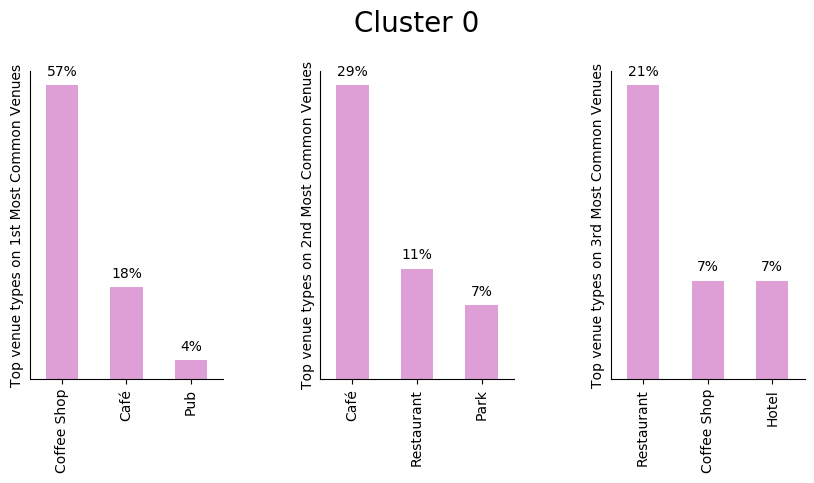

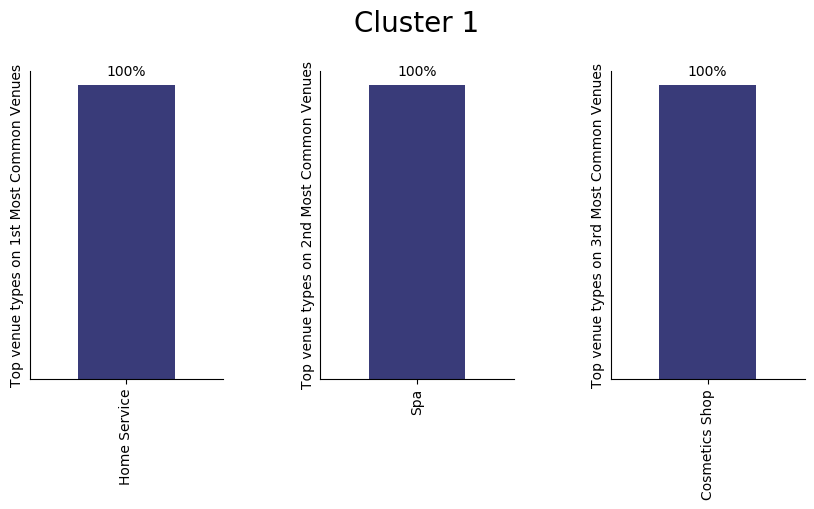

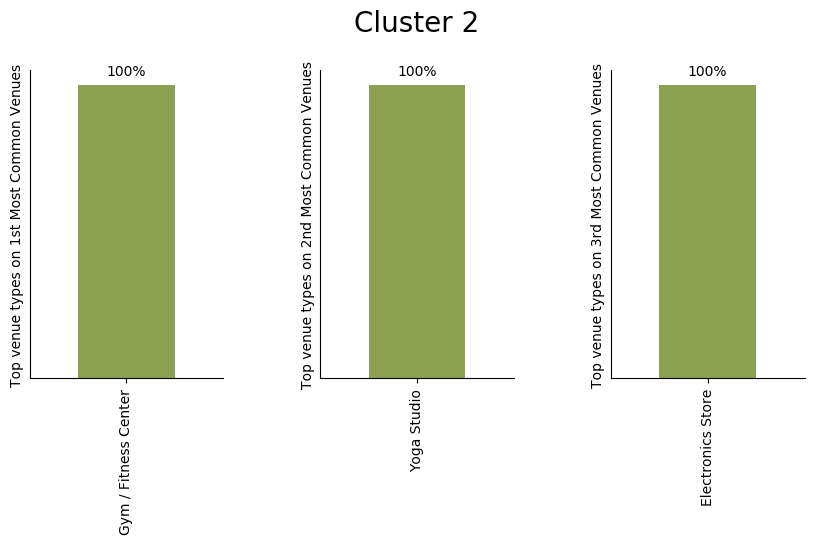

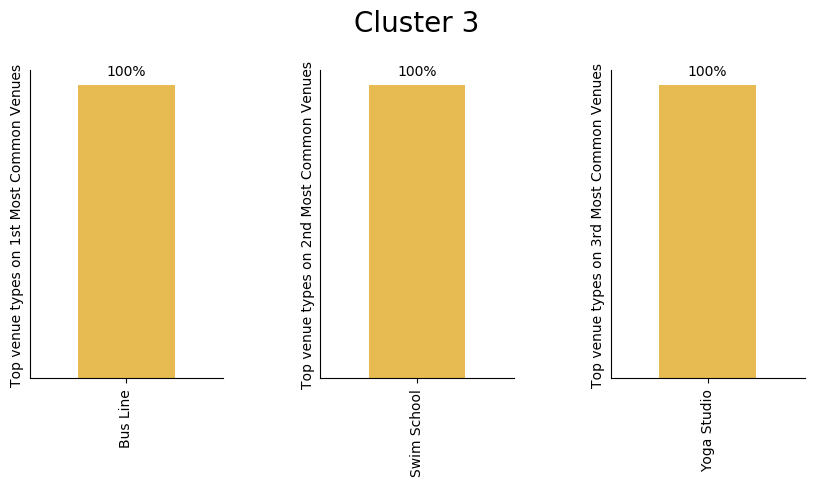

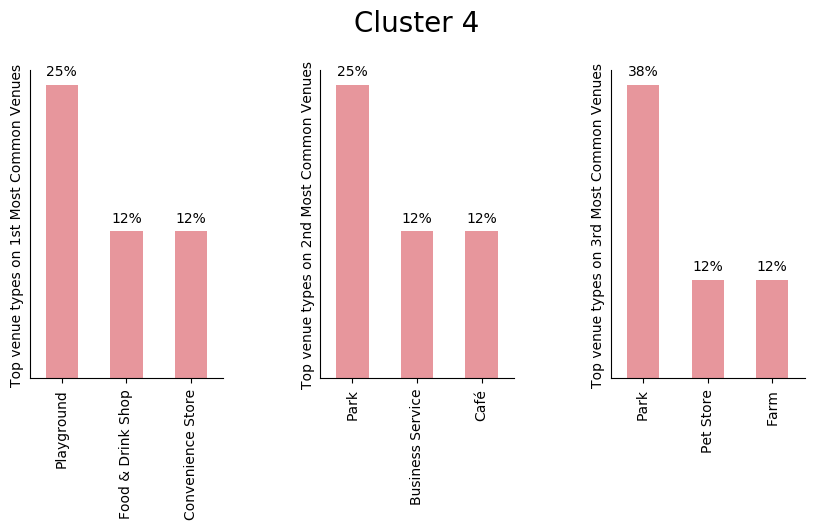

In [48]:
plotClusterAnalysis()

> ### 14.4) Descriptive results and discussions

- ## Cluster 0: mainly composed by

In [49]:
labels[0]

[['Coffee Shop', 'Café', 'Pub'],
 ['Café', 'Restaurant', 'Park'],
 ['Restaurant', 'Coffee Shop', 'Hotel']]

### Given the characteristics of this cluster, one can infer that those would be suitable areas for both tourists and locals to take a walk, enjoy a cup of coffee or even a meal at a restaurant.
---

- ## Cluster 1: mainly composed by

In [50]:
labels[1]

[['Home Service'], ['Spa'], ['Cosmetics Shop']]

### This neighborhood seems to be appropriate for shopping, relaxing activities and home services
---

- ## Cluster 2: mainly composed by

In [51]:
labels[2]

[['Gym / Fitness Center'], ['Yoga Studio'], ['Electronics Store']]

### Given the characteristics of this cluster, one can infer that it is mostly suitable for exercising, relaxing activities as well as shopping.
---

- ## Cluster 3: mainly composed by

In [52]:
labels[3]

[['Bus Line'], ['Swim School'], ['Yoga Studio']]

### This neighborhood seems to be appropriate for shopping for exercising and relaxing activities.
---

- ## Cluster 4: mainly composed by

In [53]:
labels[4]

[['Playground', 'Food & Drink Shop', 'Convenience Store'],
 ['Park', 'Business Service', 'Café'],
 ['Park', 'Pet Store', 'Farm']]

### Given the characteristics of this cluster, one can infer that those would be proper locations for residential purposes, since it has got all the infrastructure expected from comfortable residential zones.